###  Before diving into the project, let's take a look at the Determines and Tasks.

Determines
The data is a collection of 22641 Rows and 10 column variables. Each row includes a written comment as well as additional customer information. Also each row corresponds to a customer review, and includes the variables:

Feature Information:

Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.

Age: Positive Integer variable of the reviewers age.

Title: String variable for the title of the review.

Review Text: String variable for the review body.

Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.

Division Name: Categorical name of the product high level division.

Department Name: Categorical name of the product department name.

Class Name: Categorical name of the product class name.

The basic goal in this project is to predict whether customers recommend the product they purchased using the information in their Review Text. Especially, it should be noted that the expectation in this project is to use only the "Review Text" variable and neglect the other ones. Of course, if we want, we can work on other variables individually.

Project Structure is separated in five tasks: EDA, Feature Selection and Data Cleaning , Text Mining, Word Cloud and Sentiment Classification with Machine Learning.

Classically, we can start to know the data after doing the import and load operations. We need to do missing value detection for Review Text, which is the only variable we need to care about. We can drop other variables.

We will need to apply noise removal and lexicon normalization processes by using the capabilities of the nltk library to the data set that is ready for text mining.

Afterwards, we will implement Word Cloud as a visual analysis of word repetition.

Finally, we will build models with five different algorithms and compare their performance. Thus, you will determine the algorithm that makes the most accurate emotion estimation by using the information obtained from the Review Text variable.

Tasks
1. Exploratory Data Analysis
Import Modules, Load Discover the Data
2. Feature Selection and Data Cleaning
Feature Selection and Rename Column Name
Missing Value Detection
3. Text Mining
Tokenization
Noise Removal
Lexicon Normalization
4. WordCloud - Repetition of Words
Detect Reviews
Collect Words
Create Word Cloud
5. Sentiment Classification with Machine Learning
Train - Test Split
Vectorization
TF-IDF
Logistic Regression
Naive Bayes
Support Vector Machine
Random Forest
AdaBoost
Model Comparison

## 1. Exploratory Data Analysis:

#### << Import Libraries, Load and Discover the Data

In [1]:
!pip install pyforest

In [2]:
!pip install missingno


In [3]:
!pip install cufflinks
### une bibliothèque qui permet d'intégrer les visualisations Plotly avec des pandas. 

In [4]:
!pip install wordcloud


In [5]:
!pip install termcolor

In [6]:
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import plotly.express as px
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud 

C:\Users\Asus\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



#### Some Useful User Defined Functions

In [7]:
### These functions are designed to provide a comprehensive initial exploration and cleaning of a DataFrame, 
### including identifying missing values, checking for multicollinearity, removing duplicates, dropping unnecessary columns,
### and analyzing individual columns. 
### This kind of preprocessing is crucial for ensuring data quality before further analysis or modeling.


## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop related columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
        
###############################################################################

# To view summary information about the column

def first_look(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [8]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [9]:
df.tail()

Unnamed: 0  Clothing ID  Age  \
23481       23481         1104   34   
23482       23482          862   48   
23483       23483         1104   31   
23484       23484         1084   28   
23485       23485         1104   52   

                                                    Title  \
23481                      Great dress for many occasions   
23482                          Wish it was made of cotton   
23483                               Cute, but see through   
23484  Very cute dress, perfect for summer parties and we   
23485                     Please make more like this one!   

                                                                                                                                                                                                   Review Text  \
23481                                                                      I was very happy to snag this dress at such a great price! it's very easy to slip on and has a very flattering cut and color combo.   
23482  It reminds me of maternity clothes. soft, stretchy, shiny material. cut is flattering and drapes nicely. i only found one button to close front... looked awkward. nice long sleeves.\nnot for me bu...   
23483  This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with different fabric, it would have...   
23484  I bought this dress for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and sh...   
23485                                                                                           This dress in a lovely platinum is feminine and fits perfectly, easy to wear and comfy, too! highly recommend!   

       Rating  Recommended IND  Positive Feedback Count   Division Name  \
23481       5                1                        0  General Petite   
23482       3                1                        0  General Petite   
23483       3                0                        1  General Petite   
23484       3                1                        2         General   
23485       5                1                       22  General Petite   

      Department Name Class Name  
23481         Dresses    Dresses  
23482            Tops      Knits  
23483         Dresses    Dresses  
23484         Dresses    Dresses  
23485         Dresses    Dresses

In [10]:
df.sample(5)

Unnamed: 0  Clothing ID  Age  \
21673       21673         1059   67   
22700       22700         1087   42   
2613         2613          829   49   
21276       21276         1193   47   
20524       20524          870   56   

                                           Title  \
21673                            Chameleon color   
22700                  Interesting and different   
2613                                Great staple   
21276                Cute and comfortable dress!   
20524  One size is too big, the other too small!   

                                                                                                                                                                                                   Review Text  \
21673  Saying that these pants are comfortable would be redundant. they are over & above in comfort. i wear a size 8; and they are right on in sizing. i want to comment on the color/print. to see the gre...   
22700  I ordered this dress in both colors. i'm very fair and blonde and the darker dress just swallowed me up - looked really messy on me. the lighter one.....love it. it's very flowy and not form fitti...   
2613   This shirt is the perfect go-to; classic white button down, with a twist! the fit is flattering & i would have to say runs a little large. i am 5'4,124 lbs, broad shoulders, with a 36d bust and bo...   
21276                                                                                                                           This is the perfect casual yet stylish dress. and, it's extremely comfortable!   
20524  I didn't know what to put for "runs small, true to size, or runs large," but it required me to put something...i first ordered the xl, and it was ridiculously gianormous. the next time, i ordered ...   

       Rating  Recommended IND  Positive Feedback Count   Division Name  \
21673       5                0                        0         General   
22700       4                1                        0  General Petite   
2613        5                1                        5  General Petite   
21276       5                1                        0         General   
20524       3                0                        2         General   

      Department Name Class Name  
21673         Bottoms      Pants  
22700         Dresses    Dresses  
2613             Tops    Blouses  
21276         Dresses    Dresses  
20524            Tops      Knits

#####  Data Wrangling


In [11]:
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)

Shape:(23486, 11)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB
None
------------------------------------------

In [12]:
df.columns


Index(['unnamed:_0', 'clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

In [13]:
### The "Unnamed:_0" column contains completely unique values and contains the same information as the index.
### Also "clothing_id" columns has unique values over 1200.
###I'm dropping this columns because they won't work for us as they stand.
df.drop(['unnamed:_0', 'clothing_id'], axis = 1, inplace=True)

In [14]:
df.shape

(23486, 9)

In [15]:
df = df.rename(columns = {'Review Text' : 'text', 'recommended_ind' : 'recommended', 
                          'positive_feedback_count' : 'feedback_count', 'division_name' : 'division', 
                          'department_name' : 'department', 'class_name' :'class'})

In [16]:
df.describe().T

count   mean    std    min    25%    50%    75%     max
age            23486.000 43.199 12.280 18.000 34.000 41.000 52.000  99.000
rating         23486.000  4.196  1.110  1.000  4.000  5.000  5.000   5.000
recommended    23486.000  0.822  0.382  0.000  1.000  1.000  1.000   1.000
feedback_count 23486.000  2.536  5.702  0.000  0.000  1.000  3.000 122.000

In [17]:
## Columns with ordinal information, although the "rating" and "recommended_ind" columns are encoded as numeric.

df.describe(include=object).T


count unique  \
title        19676  13993   
review_text  22641  22634   
division     23472      3   
department   23472      6   
class        23472     20   

                                                                                            top  \
title                                                                                  Love it!   
review_text  Perfect fit and i've gotten so many compliments. i buy all my suits from here now!   
division                                                                                General   
department                                                                                 Tops   
class                                                                                   Dresses   

              freq  
title          136  
review_text      3  
division     13850  
department   10468  
class         6319

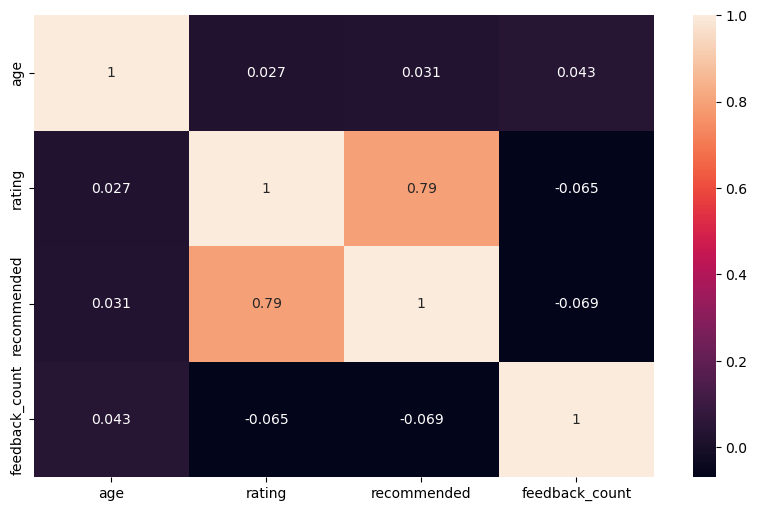

In [18]:
sns.heatmap(df.corr(), annot=True);


In [19]:
## Let us have look at the columns remaining in the dataset.
df.columns


Index(['age', 'title', 'review_text', 'rating', 'recommended',
       'feedback_count', 'division', 'department', 'class'],
      dtype='object')

#### age
  ######  Positive Integer variable of the reviewers age

In [20]:
first_look("age")

column name    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  77
39    1269
35     909
36     842
34     804
38     780
37     766
41     741
33     725
46     713
42     651
32     631
48     626
40     617
44     617
43     579
31     569
47     564
53     560
45     529
29     513
49     490
56     471
52     442
28     428
26     423
30     407
50     398
54     395
51     393
57     363
27     344
60     341
62     338
25     331
55     328
59     321
58     277
66     276
64     247
23     247
24     245
63     239
61     227
65     226
67     157
22     146
68     141
69     113
20     108
21     102
70      93
71      51
74      50
72      46
83      43
19      40
73      40
75      26
77      18
78      15
79      15
82      13
76      10
80      10
85       6
84       6
89       5
81       5
91       5
18       4
87       4
94       3
93       2
90       2
86       2
99       2
92       1
Name: age, dtype: int64


In [21]:
df.age.describe().T

count   23486.000
mean       43.199
std        12.280
min        18.000
25%        34.000
50%        41.000
75%        52.000
max        99.000
Name: age, dtype: float64

In [22]:
px.histogram(df, x = df.age)

In [23]:
pd.crosstab(df.age, df.recommended).iplot(kind="bar")

### rating

###### Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

In [24]:
first_look("rating")

column name    :  rating
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
5    13131
4     5077
3     2871
2     1565
1      842
Name: rating, dtype: int64


In [25]:
df.rating.describe().T

count   23486.000
mean        4.196
std         1.110
min         1.000
25%         4.000
50%         5.000
75%         5.000
max         5.000
Name: rating, dtype: float64

In [26]:
px.histogram(df, x = df.rating)

In [27]:
pd.crosstab(df.rating, df.recommended).iplot(kind="bar")

### recommended

##### Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.


In [28]:
first_look("recommended")

column name    :  recommended
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
1    19314
0     4172
Name: recommended, dtype: int64


In [29]:
df.recommended.describe().T

count   23486.000
mean        0.822
std         0.382
min         0.000
25%         1.000
50%         1.000
75%         1.000
max         1.000
Name: recommended, dtype: float64

In [30]:
px.histogram(df, x = df.recommended)

### feedback_count:

##### Positive Integer documenting the number of other customers who found this review positive.

In [31]:
first_look("feedback_count")

column name    :  feedback_count
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  82
0      11176
1       4043
2       2193
3       1433
4        922
5        673
6        525
7        374
8        319
9        261
10       225
11       178
12       146
14       121
13       102
15        94
17        81
16        74
18        62
19        54
20        40
23        31
21        30
22        29
25        25
28        24
26        23
24        21
27        20
30        18
31        17
29        15
32        10
42         9
37         9
38         8
34         7
35         6
36         6
33         6
51         5
81         4
45         4
39         4
65         4
43         4
40         3
47         3
57         3
41         3
44         3
53         2
49         2
46         2
58         2
55         2
64         1
89         1
68         1
56         1
48         1
98         1
93         1
95         1
50         1
99         1
87         

In [32]:
px.histogram(df, x = df.feedback_count)

In [33]:
df.feedback_count.describe().T

count   23486.000
mean        2.536
std         5.702
min         0.000
25%         0.000
50%         1.000
75%         3.000
max       122.000
Name: feedback_count, dtype: float64

### division

##### Categorical name of the product high level division.

In [34]:
first_look("division")

column name    :  division
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  3
General           13850
General Petite     8120
Initmates          1502
NaN                  14
Name: division, dtype: int64


In [35]:
df.division.describe().T

count       23472
unique          3
top       General
freq        13850
Name: division, dtype: object

In [36]:
px.histogram(df, x = df.division)

In [37]:
pd.crosstab(df.division, df.recommended).iplot(kind="bar")

### department

##### Categorical name of the product department name


In [38]:
first_look("department")

column name    :  department
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  6
Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
NaN            14
Name: department, dtype: int64


In [39]:
df.department.describe().T

count     23472
unique        6
top        Tops
freq      10468
Name: department, dtype: object

In [40]:
px.histogram(df, x = df.department)

In [41]:
pd.crosstab(df.department, df.recommended).iplot(kind="bar")

### class

###### Categorical name of the product class name.

In [42]:
first_look("class")

column name    :  class
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  20
Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
NaN                 14
Casual bottoms       2
Chemises             1
Name: class, dtype: int64


In [43]:
df["class"].describe().T

count       23472
unique         20
top       Dresses
freq         6319
Name: class, dtype: object

In [44]:
px.histogram(df, x = df["class"])

In [45]:
pd.crosstab(df["class"], df.recommended).iplot(kind="bar")

### title

###### String variable for the title of the review.

In [46]:
first_look("title")

column name    :  title
--------------------------------
per_of_nulls   :  % 16.22
num_of_nulls   :  3810
num_of_uniques :  13993
NaN                                        3810
Love it!                                    136
Beautiful                                    95
Love                                         88
Love!                                        84
                                           ... 
Not for my body                               1
Perfect transition dress                      1
The perfect spring dress!                     1
Super soft but can make you look frumpy       1
Please make more like this one!               1
Name: title, Length: 13994, dtype: int64


In [47]:
df.title.describe().T

count        19676
unique       13993
top       Love it!
freq           136
Name: title, dtype: object

### review_text

###### String variable for the review body.

In [48]:
first_look("review_text")

column name    :  review_text
--------------------------------
per_of_nulls   :  % 3.6
num_of_nulls   :  845
num_of_uniques :  22634
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       845
Perfect fit and i've gotten so many compliments. i buy all my suits from here now!                                                                                                                                                                                                                                                                                   

In [49]:
df.review_text.describe().T

count                                                                                  22641
unique                                                                                 22634
top       Perfect fit and i've gotten so many compliments. i buy all my suits from here now!
freq                                                                                       3
Name: review_text, dtype: object

#### Check Proportion of Target Class Variable:

In [50]:
df.columns

Index(['age', 'title', 'review_text', 'rating', 'recommended',
       'feedback_count', 'division', 'department', 'class'],
      dtype='object')

##### The target class variable is imbalanced, where "Recommended" values are more dominating then "Not Recommended".


1    19314
0     4172
Name: recommended, dtype: int64


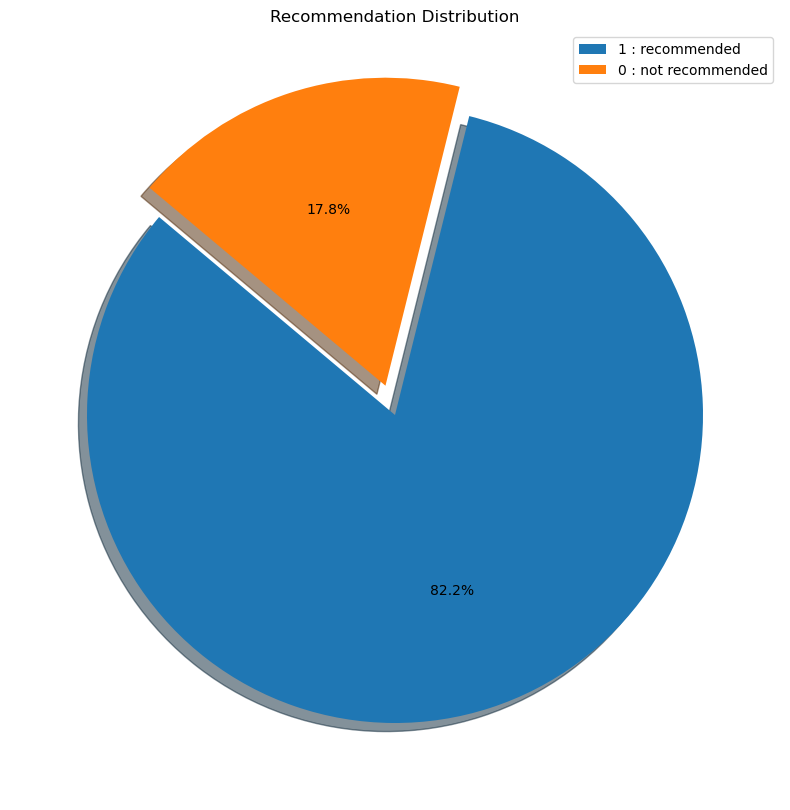

In [51]:
# recommended : 
# Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

print(df.recommended.value_counts())

plt.figure(figsize=(10,10))

explode = [0,0.1]
plt.pie(df.recommended.value_counts(), explode=explode,autopct='%1.1f%%', shadow=True,startangle=140)
plt.legend(labels=['1 : recommended','0 : not recommended'])
plt.title('Recommendation Distribution')
plt.axis('off');

### 2)  Feature Selection and Data Cleaning:

#### From now on, the DataFrame we will work with should contain two columns: "Review Text" and "Recommended IND". We can do the missing value detection operations from now on. We can also rename the column names if we want.

###### 2.1 / Feature Selection and Rename Column Name

In [52]:
df.columns

Index(['age', 'title', 'review_text', 'rating', 'recommended',
       'feedback_count', 'division', 'department', 'class'],
      dtype='object')

In [53]:
df_ml = df.copy()

# df_ml = df[['review_text', 'recommended']].copy()

In [54]:
drop_columns = ['age', 
                'title', 
                'rating',
                'feedback_count', 
                'division',
                'department',
                'class']

In [55]:
df_ml.drop(drop_columns, axis = 1, inplace = True)

In [56]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  22641 non-null  object
 1   recommended  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [57]:
df_ml.rename(columns = {'review_text':'text', 'recommended':'recommend'}, inplace = True)

In [58]:
df_ml.columns

Index(['text', 'recommend'], dtype='object')

##### 2.2 / Missing Value Detection


In [59]:
missing_values(df_ml)

Missing_Number  Missing_Percent
text             845            0.036

In [60]:
df_ml.isnull().melt(value_name="missing")

variable  missing
0           text    False
1           text    False
2           text    False
3           text    False
4           text    False
...          ...      ...
46967  recommend    False
46968  recommend    False
46969  recommend    False
46970  recommend    False
46971  recommend    False

[46972 rows x 2 columns]

<Figure size 1000x500 with 0 Axes>

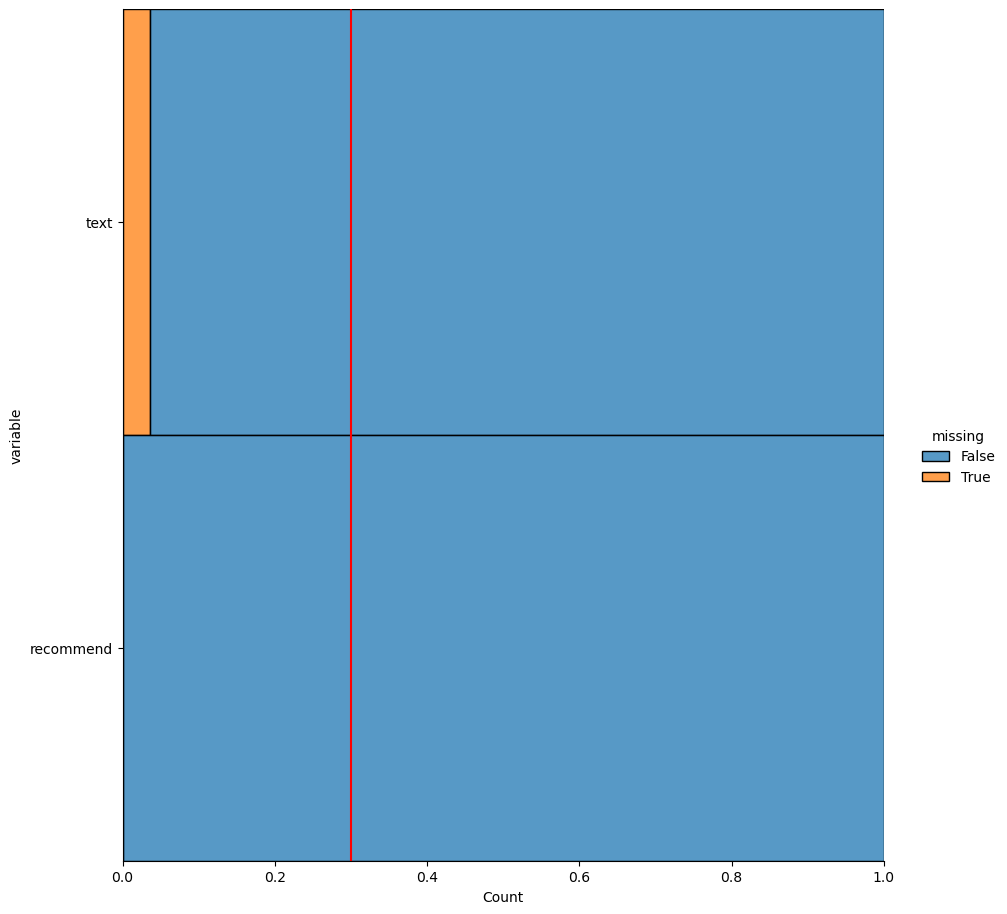

In [61]:
plt.figure(figsize = (10, 5))

sns.displot(
    data = df_ml.isnull().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    height = 9.25)

plt.axvline(0.3, color = "r");

###### Indication d'un seuil critique: Si vous analysez les données manquantes, la ligne à 0.3 (ou 30%) pourrait représenter un seuil au-delà duquel vous considérez qu'il y a trop de valeurs manquantes dans une variable, ce qui pourrait influencer votre décision de supprimer ou de traiter ces colonnes différemment.

In [62]:
df_ml = df_ml.dropna()

# df_ml = df_ml.dropna(subset=['text'], axis=0)
# df_ml = df_ml.reset_index(drop=True)

In [63]:
missing_values(df_ml)

Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []

In [64]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22641 non-null  object
 1   recommend  22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [65]:
df_ml["text"].str.isspace().sum()
df_ml[df_ml["text"].str.isspace() == True].index

Int64Index([], dtype='int64')

### 3) Text Mining

#### Text is the most unstructured form of all the available data, therefore various types of noise are present in it. This means that the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

### The three key steps of text preprocessing:

#### + Tokenization: This step is one of the top priorities when it comes to working on text mining. Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.
#### + Noise Removal: Any piece of text which is not relevant to the context of the data and the end-output can be specified as the noise. For example – language stopwords (commonly used words of a language – is, am, the, of, in etc), URLs or links, upper and lower case differentiation, punctuations and industry specific words. This step deals with removal of all types of noisy entities present in the text.
#### + Lexicon Normalization: Another type of textual noise is about the multiple representations exhibited by single word. For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”. Though they mean different things, contextually they all are similar. This step converts all the disparities of a word into their normalized form (also known as lemma). There are two methods of lexicon normalisation; Stemming or Lemmatization. Lemmatization is recommended for this case, because Lemmatization as this will return the root form of each word (rather than just stripping suffixes, which is stemming).
##### As the first step change text to tokens and convertion all of the words to lower case. Next remove punctuation, bad characters, numbers and stop words. The second step is aimed to normalization them throught the Lemmatization method.

##### ++++++  Tokenization, Noise Removal, Lexicon Normalization  +++++++

In [66]:
df_ml.head()

text  \
0                                                                                                                                                    Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length...   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...   
3                                                                             I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!   
4         This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!   

   recommend  
0          1  
1          1  
2          0  
3          1  
4          1

In [67]:
stop_words = stopwords.words('english')

In [68]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
        
    #joining
    return " ".join(text_cleaned)

In [69]:
df_ml["text"] = df_ml["text"].apply(cleaning)
df_ml["text"].head()

0                                                                                                                                                                absolutely wonderful silky sexy comfortable
1                       love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2    high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom ha...
3                                                                                                                   love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
4                                                                                             shirt flattering due adjustable front tie perfect length wear legging sleeveless pair 

#### Rare Words

In [70]:
" ".join(df_ml["text"]).split()

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'outrageously',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 's

In [71]:
rare_words = pd.Series(" ".join(df_ml["text"]).split()).value_counts()
rare_words

dress        11352
fit          10128
size          9363
love          8992
top           8280
             ...  
particle         1
deposited        1
sof              1
easel            1
platinum         1
Length: 11996, dtype: int64

In [72]:
rare_words = rare_words[rare_words <= 2] 

In [73]:
rare_words.index

Index(['greater', 'trashed', 'film', 'looove', 'damask', 'status', 'squarish',
       'allusion', 'gorge', 'doe',
       ...
       'mosly', 'retailerday', 'encouraging', 'hahahaha', 'gasped', 'particle',
       'deposited', 'sof', 'easel', 'platinum'],
      dtype='object', length=6497)

In [74]:
df_ml["text"] = df_ml["text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
df_ml["text"].head()

0                                                                                                                                                                absolutely wonderful silky sexy comfortable
1                       love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2    high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom half tight laye...
3                                                                                                                   love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
4                                                                                             shirt flattering due adjustable front tie perfect length wear legging sleeveless pair 

### 4)  WordCloud - Repetition of Words:

##### Now we'll create a Word Clouds for reviews, representing most common words in each target class.

##### Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

##### We will create separate word clouds for positive and negative reviews. We can qualify a review as positive or negative, by looking at its recommended status.

##### We can follow the steps below:

###### + Detect Reviews
###### + Collect Words
###### + Create Word Cloud

##### Detect Reviews (positive and negative separately)

In [75]:
df_ml[df_ml["recommend"] == 0].head(3)

text  \
2   high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom half tight laye...   
5   love tracy reese dress one petite foot tall usually wear brand dress pretty package lot dress skirt long full overwhelmed small frame stranger alteration shortening skirt would take away embellish...   
10       dress run small esp zipper area run ordered sp typically fit tight material top look feel cheap even pulling cause rip fabric pretty disappointed going christmas dress year needle say going back   

    recommend  
2           0  
5           0  
10          0

In [76]:
df_ml[df_ml["recommend"] == 1].head(3)

text  \
0                                                                                                                                           absolutely wonderful silky sexy comfortable   
1  love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite   
3                                                                                              love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment   

   recommend  
0          1  
1          1  
3          1

##### Collect Words (positive and negative separately)

In [77]:
" ".join(df_ml["text"]).split()

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 'shirt',
 'flatteri

In [78]:
positive_words =" ".join(df_ml[df_ml["recommend"] == 1].text).split()
positive_words

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 'shirt',
 'flattering',
 'due',
 'adjustable',
 'front',
 'tie',
 'perfect',
 'length',
 'wear',
 'legging',
 'sleeveless',
 'pair',
 'well',
 'cardigan',
 'love',
 'shirt',
 'basket',
 'hte',
 'last',
 'see',
 'would',
 'look',
 'like',
 'person',
 'store',
 'pick',
 'went',
 'teh',
 'color',
 'pale',
 'hte',
 'color',
 'really',
 'gorgeous',
 'turn',
 'trying',
 'little',
 'baggy',
 'hte',
 'x',
 'hte',
 'size',
 'bummer',
 'petite',
 'decided',
 'though',
 'said',
 'everything',
 '

In [79]:
negative_words = " ".join(df_ml[df_ml["recommend"] == 0].text).split()
negative_words 

['high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'tracy',
 'reese',
 'dress',
 'one',
 'petite',
 'foot',
 'tall',
 'usually',
 'wear',
 'brand',
 'dress',
 'pretty',
 'package',
 'lot',
 'dress',
 'skirt',
 'long',
 'full',
 'overwhelmed',
 'small',
 'frame',
 'stranger',
 'alteration',
 'shortening',
 'skirt',
 'would',
 'take',
 'away',
 'embellishment',
 'garment',
 'love',
 'color',
 'idea',
 'style',
 'work',
 'returned',
 'dress',
 'dress',
 'run',
 'small',
 'esp',
 'zipper',
 'area',
 'run',
 'ordered',
 'sp',
 'typically',
 'fit',
 'tight',
 'material',

In [80]:
len(positive_words)

516772

In [81]:
len(negative_words)

116483

###### Create Word Cloud (for most common words in recommended not recommended reviews separately)


In [82]:
review_text = df_ml["text"]

In [83]:
all_words = " ".join(review_text)

In [84]:
all_words[:100]

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store im glad bc ne'

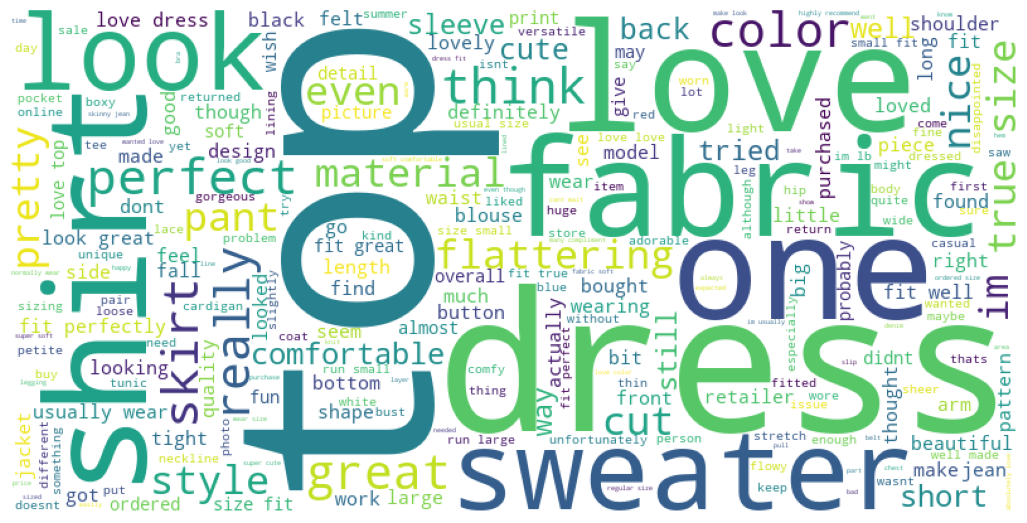

In [85]:
wordcloud = WordCloud(width = 800, height = 400, background_color = "white", max_words = 250).generate(all_words)

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

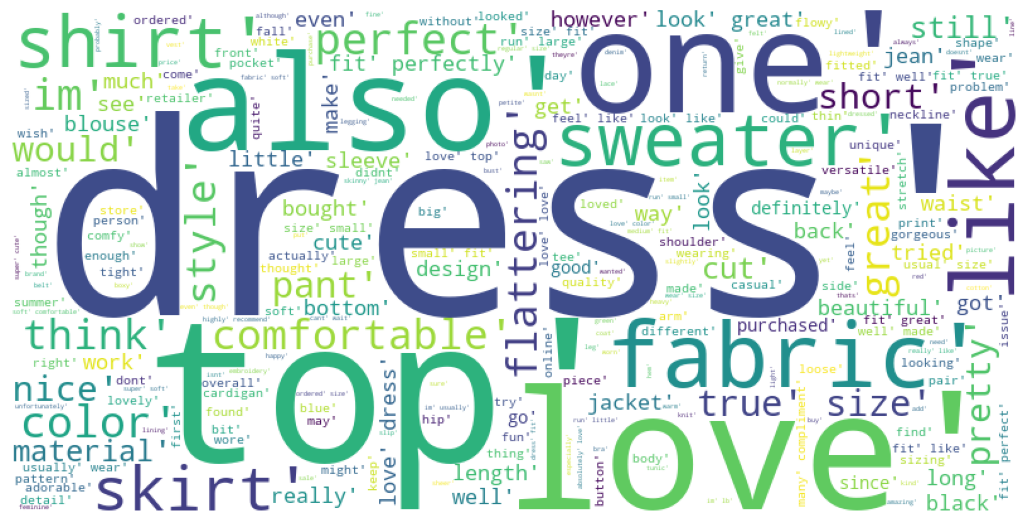

In [86]:
wordcloud = WordCloud(width = 800, height = 400, background_color = "white", max_words = 250).generate(str(positive_words))

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

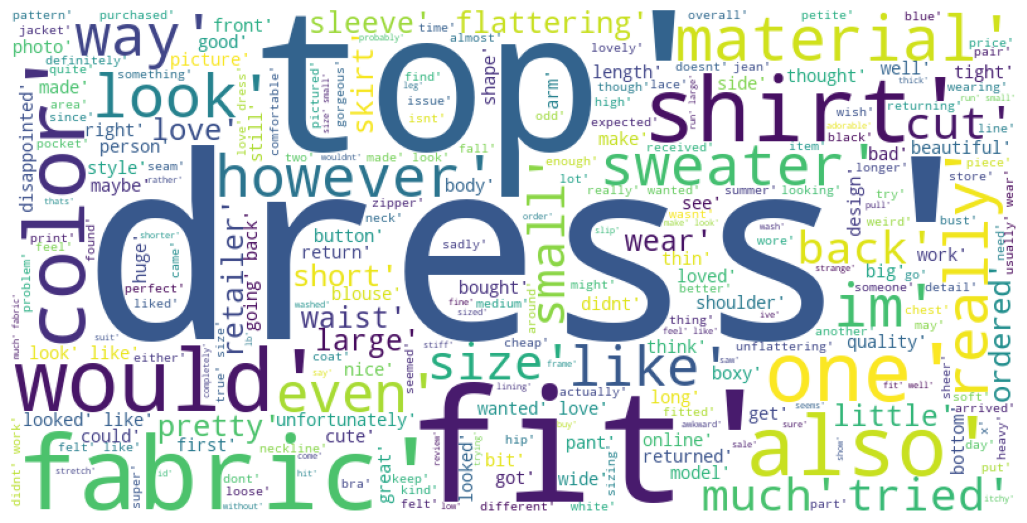

In [87]:
wordcloud = WordCloud(width = 800, height = 400, background_color = "white", max_words = 250).generate(str(negative_words))

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

###### Counting words

In [88]:
counter_all = Counter(word_tokenize(all_words))
counter_all.most_common(50)

[('dress', 11352),
 ('fit', 10128),
 ('size', 9363),
 ('love', 8992),
 ('top', 8280),
 ('like', 7036),
 ('color', 6916),
 ('look', 6890),
 ('wear', 6520),
 ('great', 6101),
 ('im', 5968),
 ('would', 5014),
 ('fabric', 4862),
 ('small', 4589),
 ('really', 3924),
 ('ordered', 3835),
 ('little', 3773),
 ('perfect', 3760),
 ('one', 3704),
 ('flattering', 3485),
 ('soft', 3322),
 ('well', 3251),
 ('back', 3186),
 ('comfortable', 3047),
 ('cute', 3030),
 ('nice', 3017),
 ('bought', 2986),
 ('beautiful', 2950),
 ('bit', 2877),
 ('material', 2811),
 ('shirt', 2791),
 ('large', 2791),
 ('much', 2703),
 ('sweater', 2699),
 ('length', 2637),
 ('run', 2631),
 ('jean', 2598),
 ('also', 2583),
 ('work', 2527),
 ('petite', 2430),
 ('got', 2426),
 ('long', 2400),
 ('short', 2361),
 ('waist', 2306),
 ('quality', 2259),
 ('medium', 2233),
 ('skirt', 2220),
 ('think', 2194),
 ('pretty', 2188),
 ('even', 2166)]

### 5) Sentiment Classification with Machine Learning and Deep Learning:


##### Before moving on to modeling, as data preprocessing steps we will need to perform vectorization and train-test split.

##### Machine learning algorithms most often take numeric feature vectors as input. Thus, when working with text documents, we need a way to convert each document into a numeric vector. This process is known as text vectorization. Commonly used vectorization approach that we will use here is to represent each text as a vector of word counts.

##### At this moment, we have our review text column as a token (which has no punctuations and stopwords). We can use Scikit-learn’s CountVectorizer to convert the text collection into a matrix of token counts. We can imagine this resulting matrix as a 2-D matrix, where each row is a unique word, and each column is a review.

##### After performing data preprocessing, we will build our models using following classification algorithms:

##### ++ Logistic Regression,
##### ++ Naive Bayes,
##### ++ Support Vector Machine,
##### ++ Random Forest,
##### ++ Ada Boosting
##### ++ Deep Learning Model.

### bag of words :

###### Train - Test Split
###### To run machine learning algorithms we need to convert text files into numerical feature vectors. We will use bag of words model for our analysis.
##### First we spliting the data into train and test sets:

In [89]:
X = df_ml["text"].values
y = df_ml["recommend"].map({0:1, 1:0}).values

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

##### In the next step we create a numerical feature vector for each document:

#### Count Vectorization

In [91]:
from sklearn.feature_extraction.text import CountVectorizer

In [92]:
vectorizer = CountVectorizer()

X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [93]:
X_train_count

<18112x5468 sparse matrix of type '<class 'numpy.int64'>'
	with 459325 stored elements in Compressed Sparse Row format>

In [94]:
X_test_count

<4529x5468 sparse matrix of type '<class 'numpy.int64'>'
	with 114118 stored elements in Compressed Sparse Row format>

In [95]:
len(X_train_count.toarray())


18112

In [96]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [97]:
len(X_test_count.toarray())

4529

In [98]:
X_test_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [99]:
pd.DataFrame(X_train_count.toarray(), columns=vectorizer.get_feature_names_out())


aa  ab  abby  abdomen  ability  able  abo  absolute  absolutely  \
0       0   0     0        0        0     0    0         0           0   
1       0   0     0        0        0     0    0         0           0   
2       0   0     0        0        0     0    0         0           0   
3       0   0     0        0        0     0    0         0           1   
4       0   0     0        0        0     0    0         0           0   
...    ..  ..   ...      ...      ...   ...  ...       ...         ...   
18107   0   0     0        0        0     0    0         0           0   
18108   0   0     0        0        0     0    0         0           0   
18109   0   0     0        0        0     0    0         0           0   
18110   0   0     0        0        0     0    0         0           1   
18111   0   0     0        0        0     0    0         0           0   

       absolutley  abstract  absurd  abt  abundance  ac  accent  accented  \
0               0         0       0    0          0   0       0         0   
1               0         0       0    0          0   0       0         0   
2               0         0       0    0          0   0       0         0   
3               0         0       0    0          0   0       0         0   
4               0         0       0    0          0   0       0         0   
...           ...       ...     ...  ...        ...  ..     ...       ...   
18107           0         0       0    0          0   0       0         0   
18108           0         0       0    0          0   0       0         0   
18109           0         0       0    0          0   0       0         0   
18110           0         0       0    0          0   0       0         0   
18111           0         0       0    0          0   0       0         0   

       accentuate  accentuated  accentuates  accentuating  accept  acceptable  \
0               0            0            0             0       0           0   
1               0            0            0             0       0           0   
2               0            0            0             0       0           0   
3               0            0            0             0       0           0   
4               0            0            0             0       0           0   
...           ...          ...          ...           ...     ...         ...   
18107           0            0            0             0       0           0   
18108           0            0            0             0       0           0   
18109           0            0            0             0       0           0   
18110           0            0            0             0       0           0   
18111           0            0            0             0       0           0   

       access  accessorize  accessorized  accessorizing  accessory  accident  \
0           0            0             0              0          0         0   
1           0            0             0              0          0         0   
2           0            0             0              0          0         0   
3           0            0             0              0          0         0   
4           0            0             0              0          0         0   
...       ...          ...           ...            ...        ...       ...   
18107       0            0             0              0          0         0   
18108       0            0             0              0          0         0   
18109       0            0             0              0          0         0   
18110       0            0             0              0          0         0   
18111       0            0             0              0          0         0   

       accidental  accidentally  accommodate  accommodates  accommodating  \
0               0             0            0             0              0   
1               0             0            0             0              0   
2               0           

In [100]:
X_train

array(['love gorgeous shade unflattering skintone make look version tied dress holding horse come fantastic fit flattering tummy rib cage size generous curve give regular',
       'found store last weekend thought perfect got size small plenty space usually small long found knee length zoom see detail work along front edge complement pretty back pocket btw worn everything summer let hope blend wash ok',
       'negative thing say color person different much coral pink pink fine tad unexpected ordered size fit perfectly chest laser cut out yoke add nice feminine unique touch otherwise basic top cant wait wear',
       ...,
       'wanted love skirt good quality front loose flap exposing return',
       'absolutely love top soft comfortable perfectly flowy definitely favorite go casual summer top',
       'purchased blue version store nice royal blue navy although could worn navy thought fit flattering middle piece pleat le obvious blue purple tie neck untied still low cut'],
      dtype

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [102]:
tf_idf_vectorizer = TfidfVectorizer()

X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [103]:
X_train_tf_idf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.29289995],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [104]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names_out())

aa    ab  abby  abdomen  ability  able   abo  absolute  absolutely  \
0     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
1     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
2     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
3     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.154   
4     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
...     ...   ...   ...      ...      ...   ...   ...       ...         ...   
18107 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
18108 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
18109 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
18110 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.324   
18111 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   

       absolutley  abstract  absurd   abt  abundance    ac  accent  accented  \
0           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
1           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
2           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
3           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
4           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
...           ...       ...     ...   ...        ...   ...     ...       ...   
18107       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18108       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18109       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18110       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18111       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   

       accentuate  accentuated  accentuates  accentuating  accept  acceptable  \
0           0.000        0.000        0.000         0.000   0.000       0.000   
1           0.000        0.000        0.000         0.000   0.000       0.000   
2           0.000        0.000        0.000         0.000   0.000       0.000   
3           0.000        0.000        0.000         0.000   0.000       0.000   
4           0.000        0.000        0.000         0.000   0.000       0.000   
...           ...          ...          ...           ...     ...         ...   
18107       0.000        0.000        0.000         0.000   0.000       0.000   
18108       0.000        0.000        0.000         0.000   0.000       0.000   
18109       0.000        0.000        0.000         0.000   0.000       0.000   
18110       0.000        0.000        0.000         0.000   0.000       0.000   
18111       0.000        0.000        0.000         0.000   0.000       0.000   

       access  accessorize  accessorized  accessorizing  accessory  accident  \
0       0.000        0.000         0.000          0.000      0.000     0.000   
1       0.000        0.000         0.000          0.000      0.000     0.000   
2       0.000        0.000         0.000          0.000      0.000     0.000   
3       0.000        0.000         0.000          0.000      0.000     0.000   
4       0.000        0.000         0.000          0.000      0.000     0.000   
...       ...          ...           ...            ...        ...       ...   
18107   0.000        0.000         0.000          0.000      0.000     0.000   
18108   0.000        0.000         0.000          0.000      0.000     0.000   
18109   0.000        0.000         0.000          0.000      0.000     0.000   
18110   0.000        0.000         0.000          0.000      0.000     0.000   
18111   0.000        0.000         0.000          0.000      0.000     0.000   

       accidental  accidentally  accommodate  accommodates  accommodating  \
0           0.000         0.000        0.000         0.000          0.000   
1          

In [105]:
X_train

array(['love gorgeous shade unflattering skintone make look version tied dress holding horse come fantastic fit flattering tummy rib cage size generous curve give regular',
       'found store last weekend thought perfect got size small plenty space usually small long found knee length zoom see detail work along front edge complement pretty back pocket btw worn everything summer let hope blend wash ok',
       'negative thing say color person different much coral pink pink fine tad unexpected ordered size fit perfectly chest laser cut out yoke add nice feminine unique touch otherwise basic top cant wait wear',
       ...,
       'wanted love skirt good quality front loose flap exposing return',
       'absolutely love top soft comfortable perfectly flowy definitely favorite go casual summer top',
       'purchased blue version store nice royal blue navy although could worn navy thought fit flattering middle piece pleat le obvious blue purple tie neck untied still low cut'],
      dtype

### TF-IDF:

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
tf_idf_vectorizer = TfidfVectorizer()

X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [108]:
X_train_tf_idf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.29289995],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [109]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names_out())

aa    ab  abby  abdomen  ability  able   abo  absolute  absolutely  \
0     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
1     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
2     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
3     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.154   
4     0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
...     ...   ...   ...      ...      ...   ...   ...       ...         ...   
18107 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
18108 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
18109 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   
18110 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.324   
18111 0.000 0.000 0.000    0.000    0.000 0.000 0.000     0.000       0.000   

       absolutley  abstract  absurd   abt  abundance    ac  accent  accented  \
0           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
1           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
2           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
3           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
4           0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
...           ...       ...     ...   ...        ...   ...     ...       ...   
18107       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18108       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18109       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18110       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   
18111       0.000     0.000   0.000 0.000      0.000 0.000   0.000     0.000   

       accentuate  accentuated  accentuates  accentuating  accept  acceptable  \
0           0.000        0.000        0.000         0.000   0.000       0.000   
1           0.000        0.000        0.000         0.000   0.000       0.000   
2           0.000        0.000        0.000         0.000   0.000       0.000   
3           0.000        0.000        0.000         0.000   0.000       0.000   
4           0.000        0.000        0.000         0.000   0.000       0.000   
...           ...          ...          ...           ...     ...         ...   
18107       0.000        0.000        0.000         0.000   0.000       0.000   
18108       0.000        0.000        0.000         0.000   0.000       0.000   
18109       0.000        0.000        0.000         0.000   0.000       0.000   
18110       0.000        0.000        0.000         0.000   0.000       0.000   
18111       0.000        0.000        0.000         0.000   0.000       0.000   

       access  accessorize  accessorized  accessorizing  accessory  accident  \
0       0.000        0.000         0.000          0.000      0.000     0.000   
1       0.000        0.000         0.000          0.000      0.000     0.000   
2       0.000        0.000         0.000          0.000      0.000     0.000   
3       0.000        0.000         0.000          0.000      0.000     0.000   
4       0.000        0.000         0.000          0.000      0.000     0.000   
...       ...          ...           ...            ...        ...       ...   
18107   0.000        0.000         0.000          0.000      0.000     0.000   
18108   0.000        0.000         0.000          0.000      0.000     0.000   
18109   0.000        0.000         0.000          0.000      0.000     0.000   
18110   0.000        0.000         0.000          0.000      0.000     0.000   
18111   0.000        0.000         0.000          0.000      0.000     0.000   

       accidental  accidentally  accommodate  accommodates  accommodating  \
0           0.000         0.000        0.000         0.000          0.000   
1          

### Modelling with Machine Learning Models:

In [110]:
!pip install -U scikit-learn

In [111]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay  # Utiliser ConfusionMatrixDisplay au lieu de plot_confusion_matrix


In [112]:
def eval(model, X_train, X_test):
    # Prédictions pour les ensembles d'entraînement et de test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Affichage des rapports de classification pour l'ensemble d'entraînement
    print("Train_Set")
    print(classification_report(y_train, y_pred_train))

    # Création et affichage de la matrice de confusion pour l'ensemble d'entraînement
    cm_train = confusion_matrix(y_train, y_pred_train)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(cmap="plasma")
    plt.title("Confusion Matrix - Training Set")
    plt.show()

    # Affichage des rapports de classification pour l'ensemble de test
    print("Test_Set")
    print(classification_report(y_test, y_pred_test))

    # Création et affichage de la matrice de confusion pour l'ensemble de test
    cm_test = confusion_matrix(y_test, y_pred_test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap="plasma")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    

### A/ Logistic Regression:

#### Countvectorizer:

In [117]:
from sklearn.linear_model import LogisticRegression

logreg_count = LogisticRegression(C = 0.1, max_iter = 1000, class_weight = 'balanced', random_state = 101)
logreg_count.fit(X_train_count,y_train)


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=101)

LogReg_Count Model
------------------
Train_Set
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     14831
           1       0.65      0.92      0.76      3281

    accuracy                           0.90     18112
   macro avg       0.81      0.91      0.85     18112
weighted avg       0.92      0.90      0.90     18112



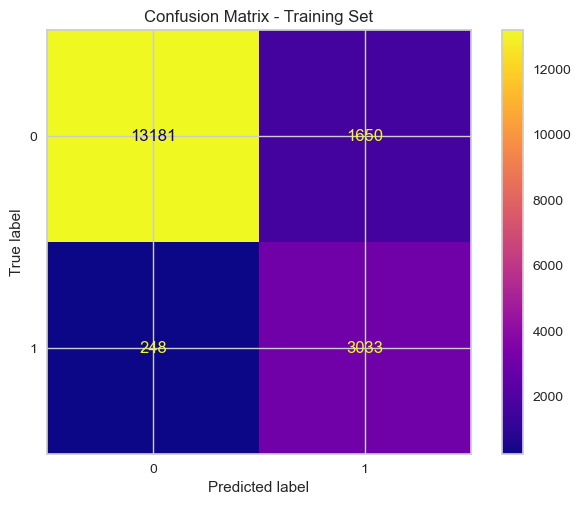

Test_Set
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3709
           1       0.58      0.85      0.69       820

    accuracy                           0.86      4529
   macro avg       0.77      0.86      0.80      4529
weighted avg       0.90      0.86      0.87      4529



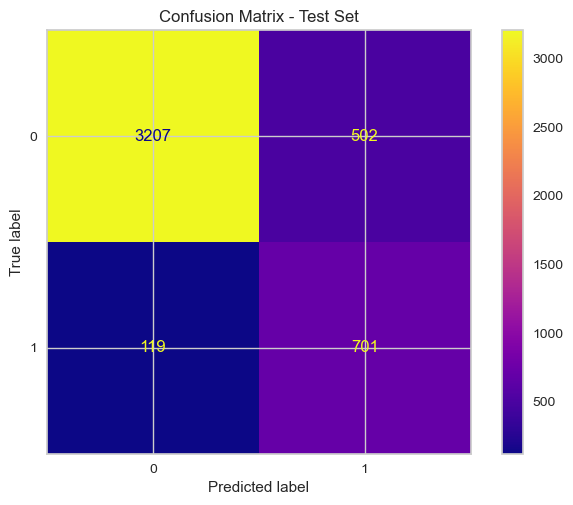

In [118]:
print("LogReg_Count Model")
print ("------------------")
eval(logreg_count, X_train_count, X_test_count)

In [119]:
import random
import pylab as pl
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

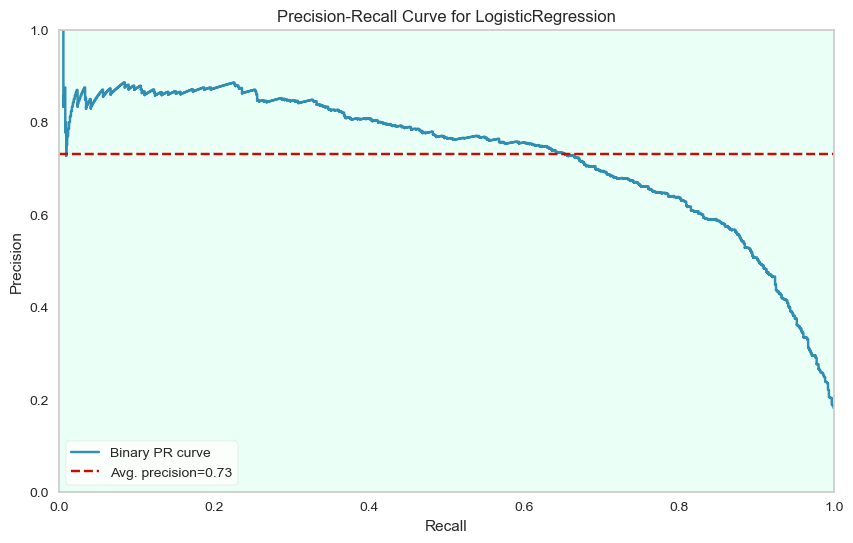

In [120]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
      LogisticRegression(C = 0.1, max_iter = 1000, class_weight= "balanced", random_state=101),
      classes = logreg_count.classes_,
      per_class = True,
      cmap = "Set1")

fig, ax = plt.subplots(figsize = (10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();


In [121]:
y_pred = logreg_count.predict(X_test_count)
log_count_rec = recall_score(y_test, y_pred, pos_label = 0, average = None)
log_count_f1 = f1_score(y_test, y_pred, pos_label = 0, average = None)
log_AP = viz.score_


In [122]:
print("viz.score_       : ", viz.score_)
print("LogReg_Count_rec : ", log_count_rec)
print("LogReg_Count_f1  : ", log_count_f1)
print("LogReg_Count_AP  : ", log_AP)

viz.score_       :  0.7315395813813119
LogReg_Count_rec :  [0.86465355 0.85487805]
LogReg_Count_f1  :  [0.91172708 0.69303015]
LogReg_Count_AP  :  0.7315395813813119


#### Countvectorizer Cross Validation 

In [124]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label = 0),
                 'recall-0': make_scorer(recall_score, pos_label = 0),
                 'f1-0': make_scorer(f1_score, pos_label = 0),
                 'precision-1': make_scorer(precision_score, pos_label = 1),
                 'recall-1': make_scorer(recall_score, pos_label = 1),
                 'f1-1': make_scorer(f1_score, pos_label = 1)
                 }

for i, j in custom_scorer.items():
    model = LogisticRegression(C = 0.1, max_iter = 1000, class_weight = "balanced", random_state = 101)
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-0":
        log_count_rec = scores
    elif i == "f1-0":
        log_count_f1 = scores
    print(f" {i:20} score for LogReg_Count : {scores}\n")

 accuracy             score for LogReg_Count : 0.8629093667226162

 precision-0          score for LogReg_Count : 0.9573403885039171

 recall-0             score for LogReg_Count : 0.8714182114276264

 f1-0                 score for LogReg_Count : 0.9123466751155744

 precision-1          score for LogReg_Count : 0.5867572062001051

 recall-1             score for LogReg_Count : 0.8244486248053968

 f1-1                 score for LogReg_Count : 0.6854935494059937



In [125]:
import random
import pylab as pl
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

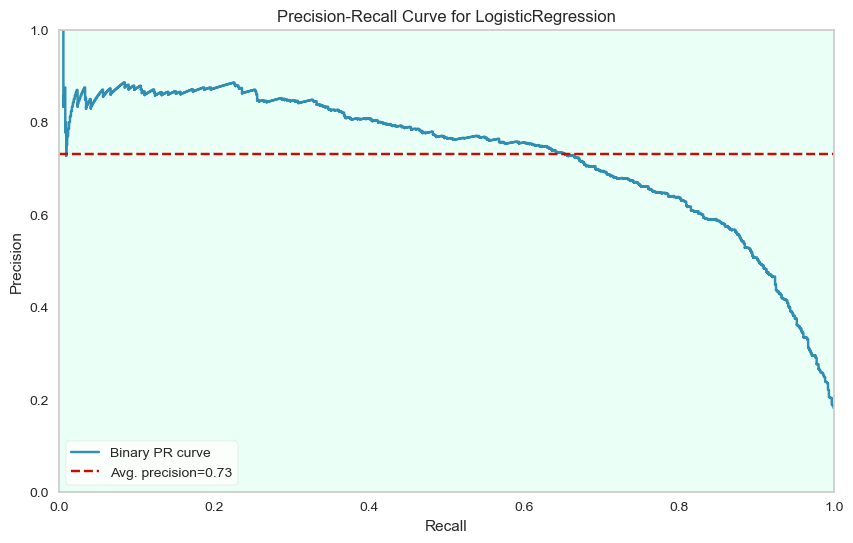

In [126]:
from yellowbrick.classifier import PrecisionRecallCurve
viz = PrecisionRecallCurve(
    LogisticRegression(C = 0.1, max_iter = 1000, class_weight = "balanced", random_state = 101),
    classes = logreg_count.classes_,
    per_class = True,
    cmap = "Set1")

fig, ax = plt.subplots(figsize = (10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [127]:
LogReg_Count_AP = viz.score_
LogReg_Count_AP

0.7315395813813119

### TF-IDF:

In [133]:
logreg_tfidf = LogisticRegression(C = 1, max_iter = 1000, class_weight = "balanced", random_state = 101)
logreg_tfidf.fit(X_train_tf_idf,y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   random_state=101)

LogReg_TFIDF Model
------------------
Train_Set
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     14831
           1       0.64      0.93      0.76      3281

    accuracy                           0.89     18112
   macro avg       0.81      0.91      0.85     18112
weighted avg       0.92      0.89      0.90     18112



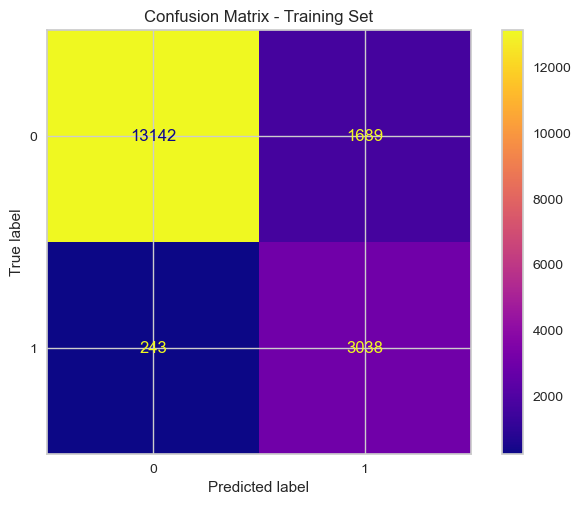

Test_Set
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      3709
           1       0.58      0.87      0.70       820

    accuracy                           0.86      4529
   macro avg       0.77      0.86      0.80      4529
weighted avg       0.90      0.86      0.87      4529



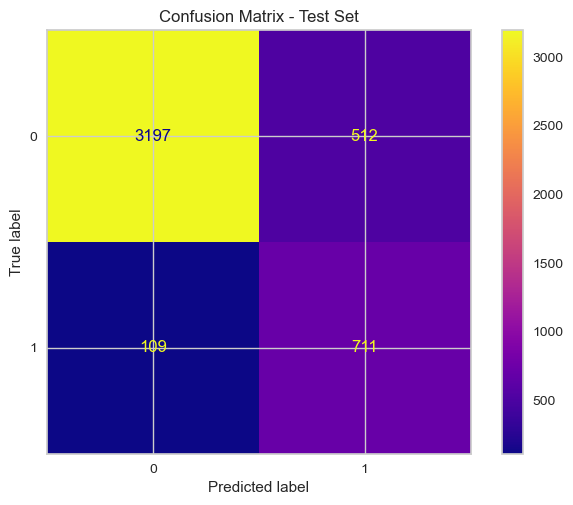

In [134]:
print("LogReg_TFIDF Model")
print("------------------")
eval(logreg_tfidf, X_train_tf_idf, X_test_tf_idf)

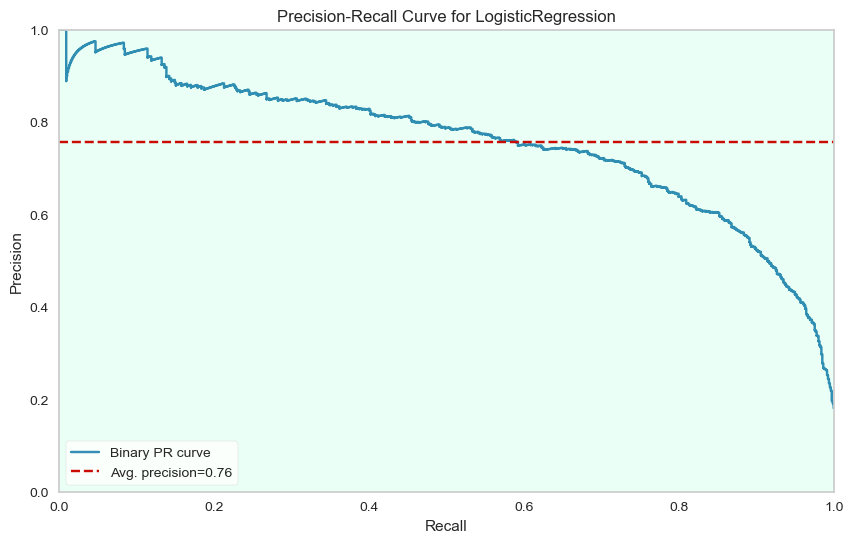

In [135]:
from yellowbrick.classifier import PrecisionRecallCurve
viz = PrecisionRecallCurve(
    LogisticRegression(C = 1, max_iter = 1000, class_weight = "balanced", random_state=101),
    classes = logreg_count.classes_,
    per_class = True,
    cmap = "Set1")

fig, ax = plt.subplots(figsize = (10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [136]:
y_pred = logreg_tfidf.predict(X_test_tf_idf)
log_tf_idf_rec = recall_score(y_test, y_pred, pos_label = 0, average = None)
log_tf_idf_f1 = f1_score(y_test, y_pred, pos_label = 0, average = None)
log_tf_idf_AP = viz.score_

In [137]:
print("viz.score_       : ", viz.score_)
print("LogReg_TFIDF_rec : ", log_tf_idf_rec)
print("LogReg_TFIDF_f1  : ", log_tf_idf_f1)
print("LogReg_TFIDF_AP  : ", log_tf_idf_AP)

viz.score_       :  0.7574117487739018
LogReg_TFIDF_rec :  [0.8619574  0.86707317]
LogReg_TFIDF_f1  :  [0.91147541 0.69603524]
LogReg_TFIDF_AP  :  0.7574117487739018


### TF-IDF Cross Validation:

In [138]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label = 0),
                 'recall-0': make_scorer(recall_score, pos_label = 0),
                 'f1-0': make_scorer(f1_score, pos_label = 0),
                 'precision-1': make_scorer(precision_score, pos_label = 1),
                 'recall-1': make_scorer(recall_score, pos_label = 1),
                 'f1-1': make_scorer(f1_score, pos_label = 1)
                 }

for i, j in custom_scorer.items():
    LogisticRegression(C = 1, max_iter = 1000, random_state = 101, class_weight = "balanced")
    scores = cross_val_score(model, X_train_tf_idf, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        log_tfidf_rec = scores
    elif i == "f1-1":
        log_tfidf_f1 = scores
    print(f" {i:20} score for LogReg_TFIDF : {scores}\n")

 accuracy             score for LogReg_TFIDF : 0.8467867447277675

 precision-0          score for LogReg_TFIDF : 0.9637855005397291

 recall-0             score for LogReg_TFIDF : 0.844649332143448

 f1-0                 score for LogReg_TFIDF : 0.9002805757635913

 precision-1          score for LogReg_TFIDF : 0.5495203188785063

 recall-1             score for LogReg_TFIDF : 0.8564459930313589

 f1-1                 score for LogReg_TFIDF : 0.6694238015639403



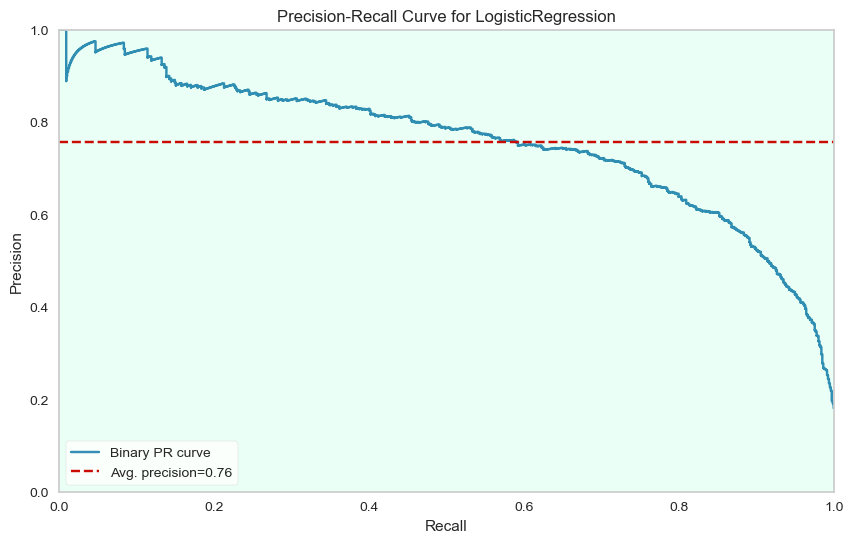

In [139]:
viz = PrecisionRecallCurve(
    LogisticRegression(C = 1, max_iter = 1000, random_state = 101, class_weight = "balanced"),
    classes = logreg_tfidf.classes_,
    per_class = True,
    cmap = "Set1")

fig, ax = plt.subplots(figsize = (10, 6))
ax.set_facecolor('#eafff5')

viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [140]:
LogReg_TFIDF_AP = viz.score_
LogReg_TFIDF_AP

0.7574117487739018